In [1]:
import torch
torch.__version__

'1.6.0'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")
print(device)

cuda:0


# Data generation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def function_2d(x,y):
    ### shape ### x,y:(num_ins,1) 
    
    term_sqrt = np.sqrt(x*x+y*y)
    term1 = np.sin(20*term_sqrt)/(20*term_sqrt)
    term2 = (1/5)*np.cos(10*term_sqrt)
    term3 = y/2 - 0.3
    
    label = term1 + term2 + term3
    
    return label
    ###shape### label : (num_ins,1)

# generate dataset
def generate_data(dim):
    
    #generate 100x100 points
    x = np.linspace(-1,1,dim)
    y = np.linspace(-1,1,dim)
    xx,yy = np.meshgrid(x,y)
    ###shape### xx,yy : (dim,dim)
    zz = function_2d(xx,yy)
    ###shape### zz : (dim,dim)
    
    # add noise
    noise = np.random.standard_normal((dim,dim))
    zz = zz + 0.1*noise
    
    # create dataset
    data1 = xx.reshape(-1,1)
    data2 = yy.reshape(-1,1)
    label = zz.reshape(-1,1)
    dataset = np.hstack((data1,data2))
    dataset = np.hstack(((dataset,label)))
    ###shape### dataset : (dim*dim,3) np.array
    return torch.Tensor(dataset)

dataset= generate_data(100)

In [4]:
dataset[0][0:2]

tensor([-1., -1.])

In [5]:
from sklearn.model_selection import train_test_split
trainset, validset = train_test_split(dataset, test_size=0.3, random_state=0)
validset, testset = train_test_split(validset,test_size=0.5,random_state=0)

# Define Network

In [67]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

#ngpu = 1
#hidden_neurons = 16
class MLP(nn.Module):
    def __init__(self, ngpu, hidden_neurons):
        super(MLP, self).__init__()
        self.ngpu = ngpu
        self.hidden_neurons = hidden_neurons
        self.main = nn.Sequential(
            nn.Linear(2,hidden_neurons),
            nn.Sigmoid(),
            nn.Linear(hidden_neurons,1),
        )

    def forward(self, x):
        x = x.view(-1,2)
        return self.main(x)
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0,1.0)
        torch.nn.init.zeros_(m.bias.data)

In [68]:
# print("Generator's state_dict:\n")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t ", model.state_dict()[param_tensor].size())

In [69]:
# from torchsummary import summary
# summary(model, (1,1,2))

# Loss & Optimizer

In [70]:
from torch.autograd import Variable
def rmse(output ,label):
    sum0 = 0
    for i in range(0,1500):
        
        term1 = float(output[i])-float(label[i])
        term2 = term1 * term1
        sum0 = sum0 + term2
        
    result = np.sqrt(sum0/1500)
    #result = torch.Tensor(result)
    result = torch.from_numpy(np.array(result))
    result = Variable(result,requires_grad=True)
    return result
   # return torch.from_numpy(result)
    
criterian = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)

# Define Train Validation and Test

In [71]:
def train(epoch):
    #print('epoch : ',epoch+1)
    model.train() 

    inputs = Variable(trainset[:,0:2]).view(7000, 2)#.to(device)
    labels = Variable(trainset[:,2]).view(7000, 1)#.to(device)
    
    optimizer.zero_grad()

    outputs = model(inputs)
   # train_out.append(outputs)

    loss = criterian(outputs,labels)
#     if(epoch%3000==0 or epoch==num_epochs-1):
#         print(epoch,loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    
def valid(epoch):
    model.eval()
    with torch.no_grad():

        inputs = Variable(validset[:,0:2]).view(1500, 2)#.to(device)
        labels = Variable(validset[:,2]).view(1500, 1)#.to(device)

        outputs = model(inputs)

        loss = rmse(outputs,labels)
        estimated = np.hstack((inputs,outputs))
        if(epoch%10000==0 or epoch==num_epochs-1):
            print("\t\t\t",epoch,'valid: Loss: {:.4f}'.format(loss.item()))      
    #scheduler.step()      
    return loss.item(),estimated
    
def test(epoch):
    model.eval()
    with torch.no_grad():

        inputs = Variable(testset[:,0:2]).view(1500, 2)#.to(device)
        labels = Variable(testset[:,2]).view(1500, 1)#.to(device)

        outputs = model(inputs)

        loss = rmse(outputs,labels)
        estimated = np.hstack((inputs,outputs))
        if(epoch%10000==0 or epoch==num_epochs-1):
            print("\t\t\t",epoch,'test: Loss: {:.4f}'.format(loss.item()))
    #scheduler.step()    
    return loss.item(),estimated

In [60]:
model=MLP(1,77)#.to(device)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=0.095)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer
        , milestones=[15000], gamma=0.3)
trainset, validset = train_test_split(dataset,train_size=7000 ,test_size=1500, random_state=0)
num_epochs=35000
for epoch in range(0,num_epochs):
    train(epoch)
   # valid(epoch)

0 18.002761840820312
3000 0.040457602590322495
6000 0.03880329802632332
9000 0.03680117428302765
12000 0.03581668436527252
15000 0.03506678342819214
18000 0.0343940369784832
21000 0.03449838608503342
24000 0.034201644361019135
27000 0.03408714011311531


KeyboardInterrupt: 

# Nested CV

In [73]:
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

hidden_neurons=[16,24,32,40,48,56,77]
num_epochs=25000
model_selection=99 # just big number
dataset= generate_data(100)
a=[]
Err_val=[]  
Err_test=[]
mean_Err_test_list=[]
mean_Err_val_list=[]
min_mean_Err_val=101
#dataset_shuffled=dataset[torch.randperm(len(dataset))]
learningset, testset = train_test_split(dataset,train_size=8500 ,test_size=1500, random_state=0)
for outterfold in range(0,3):
    print("-"*40)
    print("outterfold :",outterfold+1,"\n")
    for h in range(0,7):
        print("\thidden neurons",hidden_neurons[h],"\n")
        Err_val=[]
        for innerfold in range(0,3):
            trainset, validset = train_test_split(learningset,train_size=7000 ,test_size=1500, random_state=0)
            print("\t\tinnerfold : ",innerfold+1)
            model=MLP(1,hidden_neurons[h])#.to(device)
            model.apply(weights_init)
            optimizer = optim.Adam(model.parameters(), lr=0.095)
            scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[15000], gamma=0.3)
            temp=[]
            for epoch in range(0,num_epochs):
                train(epoch)
                a,_ = valid(epoch)
                temp.append(a)
            print("\t\t\t\tErr_val :",np.min(temp),"\n")
            Err_val.append(np.min(temp))
        mean_Err_val=sum(Err_val)/3.0
        print("\t\t\t\t\tmean_Err_val =",mean_Err_val,"\n")
        mean_Err_val_list.append(mean_Err_val)
        #choose the best model
        if(min_mean_Err_val>mean_Err_val):
            min_mean_Err_val = mean_Err_val
            model_selection = hidden_neurons[h]
    model=MLP(1,model_selection)#.to(device)
    model.apply(weights_init)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)
    print("\t\t\t\tbest model :",model_selection)
    temp=[]
    for epoch in range(0,num_epochs):
        train(epoch)
        a,_ = test(epoch)
        temp.append(a)
    print("\t\t\t\tErr_test :",np.min(temp))
    Err_test.append(np.min(temp))
    print("-"*40)

----------------------------------------
outterfold : 1 

	hidden neurons 16 

		innerfold :  1
			 0 valid: Loss: 0.3983
			 10000 valid: Loss: 0.1598
			 20000 valid: Loss: 0.1561
			 24999 valid: Loss: 0.1553
				Err_val : 0.1552669504156824 

		innerfold :  2
			 0 valid: Loss: 0.4956
			 10000 valid: Loss: 0.1552
			 20000 valid: Loss: 0.1506
			 24999 valid: Loss: 0.1497
				Err_val : 0.14973879754839642 

		innerfold :  3
			 0 valid: Loss: 3.1250
			 10000 valid: Loss: 0.1565
			 20000 valid: Loss: 0.1533
			 24999 valid: Loss: 0.1530
				Err_val : 0.15303205665468594 

					mean_Err_val = 0.1526792682062549 

	hidden neurons 24 

		innerfold :  1
			 0 valid: Loss: 0.7163
			 10000 valid: Loss: 0.1474
			 20000 valid: Loss: 0.1436
			 24999 valid: Loss: 0.1426
				Err_val : 0.14230236025376666 

		innerfold :  2
			 0 valid: Loss: 0.6324
			 10000 valid: Loss: 0.1587
			 20000 valid: Loss: 0.1513
			 24999 valid: Loss: 0.1492
				Err_val : 0.14819596443270697 

		innerfold :  

			 10000 test: Loss: 0.1863
			 20000 test: Loss: 0.1643
			 24999 test: Loss: 0.1621
				Err_test : 0.16207608293850098
----------------------------------------
----------------------------------------
outterfold : 3 

	hidden neurons 16 

		innerfold :  1
			 0 valid: Loss: 0.3818
			 10000 valid: Loss: 0.1503
			 20000 valid: Loss: 0.1489
			 24999 valid: Loss: 0.1488
				Err_val : 0.14882455666782385 

		innerfold :  2
			 0 valid: Loss: 1.3273
			 10000 valid: Loss: 0.1577
			 20000 valid: Loss: 0.1541
			 24999 valid: Loss: 0.1530
				Err_val : 0.1529767525575292 

		innerfold :  3
			 0 valid: Loss: 0.8146
			 10000 valid: Loss: 0.1488
			 20000 valid: Loss: 0.1405
			 24999 valid: Loss: 0.1403
				Err_val : 0.14031344054482958 

					mean_Err_val = 0.14737158325672756 

	hidden neurons 24 

		innerfold :  1
			 0 valid: Loss: 0.4462
			 10000 valid: Loss: 0.1635
			 20000 valid: Loss: 0.1340
			 24999 valid: Loss: 0.1343
				Err_val : 0.1338643285806713 

		innerfold :  2
			 

In [ ]:
mean_Err_test_list

In [93]:
model=MLP(1,77)#.to(device)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=0.1)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)

In [94]:
for epoch in range(0,15000):
    train(epoch)
    #_,estimated=valid(epoch)

In [95]:
model.eval()
with torch.no_grad():

    inputs = Variable(dataset[:,0:2]).view(10000, 2)#.to(device)
    labels = Variable(dataset[:,2]).view(10000, 1)#.to(device)

    outputs = model(inputs)

    loss = rmse(outputs,labels)
    estimated = np.hstack((inputs,outputs))
    if(epoch%3000==0 or epoch==num_epochs-1):
        print("\t\t\t",epoch,'valid: Loss: {:.4f}'.format(loss.item()))      
      


In [96]:
estimated.shape

(10000, 3)

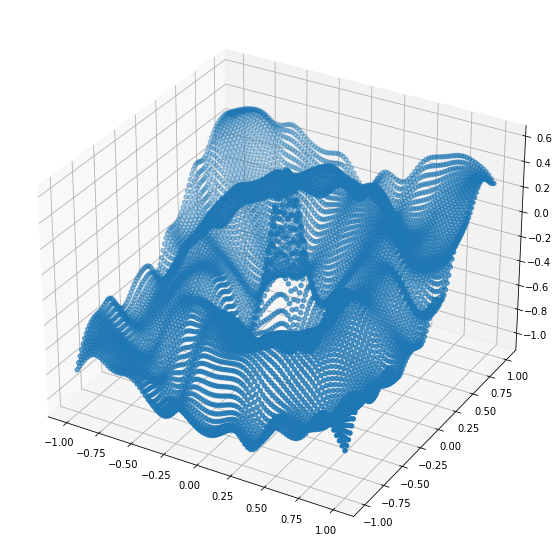

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize =(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)
xx,yy = np.meshgrid(x,y)
zz = function_2d(xx,yy)
noise = np.random.standard_normal((100,100))
zz = zz + 0.1*noise

aa=estimated[:,2]
bb=np.resize(aa,(100,100))

ax.scatter(xx, yy, bb)


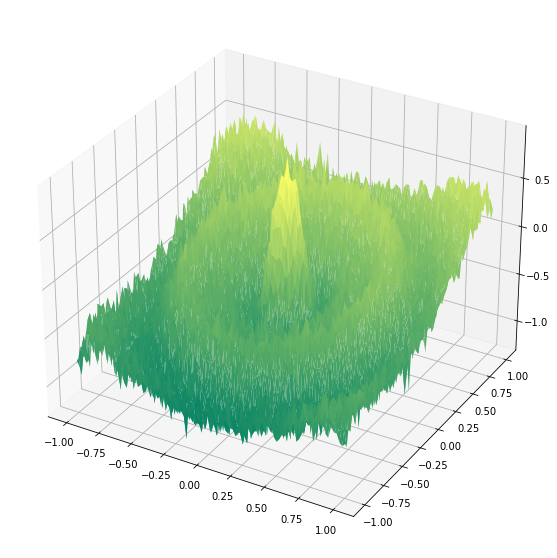

In [101]:
fig = plt.figure(figsize =(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='summer')